In [1]:
!pip install tensorflow

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pickle as pickle
import pandas as pd
import math

import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.preprocessing import normalize

import os
import time
import tensorflow as tf
from tensorflow import keras

from keras.utils import to_categorical

from keras.models import Sequential
from keras.models import load_model

from keras.layers import Conv1D, MaxPooling1D
from keras.layers import BatchNormalization, Activation, Dropout, Flatten, Dense

from keras.layers import Bidirectional, TimeDistributed
from keras.layers import LSTM, GRU, SimpleRNN

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.regularizers import l2

from sklearn.metrics import confusion_matrix, classification_report

DATASET PREPARATION

DATA PREPROCESSING

1. LABEL MAPPING

In [6]:
def label_mapping(valence, arousal):
    # HVHA, HVLA, LVHA, and LVLA
    if (valence > 5 and arousal > 5):
        return 0  # 'HVHA'
    elif (valence > 5 and arousal <= 5):
        return 1  # 'HVLA'
    elif (valence <= 5 and arousal > 5):
        return 2  # 'LVHA'
    elif (valence <= 5 and arousal <= 5):
        return 3  # 'LVLA'

def map_label(label):
    return label_mapping(label[0], label[1])


2. LOADING FILE

In [11]:
def load_deap_data(file_path):
    """Load the DEAP dataset from the given file path."""
    with open(file_path, 'rb') as file:
        data = pickle.load(file, encoding='latin1')
    return data


3. Slice Data into Epochs : Process the data by slicing it into epochs based on the specified window size and step sizes.

4. Save Processed Data: Save the processed epochs for each subject as a .npy file.

In [12]:
def slice_epochs(data, labels, window_size, step_size, channels):
    epochs = []
    epoch_labels = []

    start = 0
    while start + window_size <= data.shape[1]:
        epoch_data = data[channels, start:start + window_size]
        epochs.append(epoch_data)
        epoch_labels.append(map_label(labels))
        start += step_size

    return np.array(epochs), np.array(epoch_labels)

def process_and_save_subject(subject, data_dir, channels, window_size, step_size):
    file_path = os.path.join(data_dir, 's' + subject + '.dat')
    participant_data = load_deap_data(file_path)

    all_epochs = []
    all_labels = []

    for trial in range(40):
        data = participant_data['data'][trial]
        labels = participant_data['labels'][trial]

        epochs, epoch_labels = slice_epochs(data, labels, window_size, step_size, channels)
        all_epochs.append(epochs)
        all_labels.append(epoch_labels)

    all_epochs = np.concatenate(all_epochs)
    all_labels = np.concatenate(all_labels)

    save_path = os.path.join(data_dir, 'processed', 's' + subject + '.npy')
    np.save(save_path, {'data': all_epochs, 'labels': all_labels})

# Define parameters
data_dir = "/content/drive/MyDrive/DEAP/data_preprocessed_python"
processed_dir = os.path.join(data_dir, 'processed')
os.makedirs(processed_dir, exist_ok=True)
subject_list = ['{:02d}'.format(i) for i in range(1, 33)]  # List of subjects '01' to '32'
channels = list(range(37))  # First 37 channels
window_size = 256  # Window size for epochs
step_size = 256  # Step size for epochs

# Process and save data for all subjects
for subject in subject_list:
    process_and_save_subject(subject, data_dir, channels, window_size, step_size)
    print(f"Processed and saved subject {subject}")

Processed and saved subject 01
Processed and saved subject 02
Processed and saved subject 03
Processed and saved subject 04
Processed and saved subject 05
Processed and saved subject 06
Processed and saved subject 07
Processed and saved subject 08
Processed and saved subject 09
Processed and saved subject 10
Processed and saved subject 11
Processed and saved subject 12
Processed and saved subject 13
Processed and saved subject 14
Processed and saved subject 15
Processed and saved subject 16
Processed and saved subject 17
Processed and saved subject 18
Processed and saved subject 19
Processed and saved subject 20
Processed and saved subject 21
Processed and saved subject 22
Processed and saved subject 23
Processed and saved subject 24
Processed and saved subject 25
Processed and saved subject 26
Processed and saved subject 27
Processed and saved subject 28
Processed and saved subject 29
Processed and saved subject 30
Processed and saved subject 31
Processed and saved subject 32


5. Load Processed Data: Load the saved .npy files and perform further taskS.

In [14]:
def load_processed_data(data_dir, subject_list):
    all_data = []
    all_labels = []

    for subject in subject_list:
        file_path = os.path.join(data_dir, 'processed', 's' + subject + '.npy')
        processed_data = np.load(file_path, allow_pickle=True).item()
        all_data.append(processed_data['data'])
        all_labels.append(processed_data['labels'])

    all_data = np.concatenate(all_data)
    all_labels = np.concatenate(all_labels)

    return all_data, all_labels

# Load processed data
data, labels = load_processed_data(data_dir, subject_list)

# Print the shape of the processed data and labels
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)


Data shape: (39680, 37, 256)
Labels shape: (39680,)


LABEL COUNT

In [16]:
unique_labels, counts = np.unique(labels, return_counts=True)
print("\nUnique labels and their counts:")
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count} samples")


Unique labels and their counts:
Label 0: 13609 samples
Label 1: 8339 samples
Label 2: 9238 samples
Label 3: 8494 samples


In [17]:
print("\nFirst 5 data samples (flattened):")
for i in range(5):
    print(f"Sample {i+1} shape: {data[i].shape}")
    print(f"Sample {i+1} data (first 10 values): {data[i][:10]}")  # print first 10 values

print("\nFirst 5 labels:")
print(labels[:5])


First 5 data samples (flattened):
Sample 1 shape: (37, 256)
Sample 1 data (first 10 values): [[ 0.94823168  1.65333533  3.01372577 ... -3.73937713 -7.66415078
  -8.0763136 ]
 [ 0.12470659  1.3900827   1.83509881 ... -6.12544412 -9.23162674
  -7.32168492]
 [-2.21651099  2.29201682  2.74636923 ... -4.71192216 -8.02771165
  -9.19645928]
 ...
 [ 1.86166369  7.19064804  5.90649791 ... -0.13745779 -0.58317362
   1.42763303]
 [ 3.68900784  4.70100881  1.71287874 ...  0.13367872  2.0192396
   5.00992051]
 [ 1.3198187  -3.85322704 -6.44470803 ... -0.55104219  0.77897507
   3.07901885]]
Sample 2 shape: (37, 256)
Sample 2 data (first 10 values): [[-2.42402522  3.48663323  1.3035003  ... -3.82671962  1.88120781
   4.28186327]
 [-2.94304139  1.79995605  1.2119363  ... -2.57083277  0.28907835
   1.87000788]
 [-5.01166888  1.9767587   1.6026786  ... -2.76766987 -4.45589318
  -3.47310958]
 ...
 [-0.60888903 -1.1237364   0.09874173 ... -5.46140422 -6.95611846
   0.11568342]
 [ 4.74478398  2.63624014  

Reduce data and select only data points from end to recognize emotion

Can be used to reduce data size

Not used further, complete data considered

In [18]:
import numpy as np

# Define new window size
new_window_size = 128

# Function to reshape data
def reshape_data(data, new_window_size):
    num_samples, channels, original_size = data.shape

    # Check if new_window_size is less than or equal to the points per channel
    if new_window_size > original_size:
        raise ValueError(f"new_window_size should be <= {original_size}")

    new_data = []

    for sample in data:
        reshaped_sample = []
        for channel in range(channels):
            # Select only the last new_window_size points for each channel
            reshaped_sample.append(sample[channel, -new_window_size:])

        new_data.append(reshaped_sample)

    return np.array(new_data)

# Reshape the data to only include the last 128 points from each channel
data_reduced = reshape_data(data, new_window_size)

# Check the new shapes
print("Reduced Data shape:", data_reduced.shape)
print("Labels shape (unchanged):", labels.shape)


Reduced Data shape: (39680, 37, 128)
Labels shape (unchanged): (39680,)


SAVE FINAL DATASETS: DATA AND LABELS

In [19]:
np.save('/content/drive/MyDrive/DEAP/data', np.array(data), allow_pickle=True, fix_imports=True)
np.save('/content/drive/MyDrive/DEAP/labels', np.array(labels), allow_pickle=True, fix_imports=True)
print("Training datasets:", np.array(data).shape, np.array(labels).shape)

Training datasets: (39680, 37, 256) (39680,)


LOAD DATA

In [20]:
with open('/content/drive/MyDrive/DEAP/data.npy', 'rb') as fileTrain:
    data  = np.load(fileTrain)

with open('/content/drive/MyDrive/DEAP/labels.npy', 'rb') as fileTrainL:
    label  = np.load(fileTrainL)

In [21]:
print(data.shape)
print(label.shape)

(39680, 37, 256)
(39680,)


TRAIN TEST VAL SPLIT

In [24]:
x_train, x, y_train, y = train_test_split(data, label, test_size=0.2, random_state=42)

In [25]:
x_val, x_test, y_val, y_test = train_test_split(x, y, test_size=0.5, random_state=42)

In [26]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(31744, 37, 256)
(31744,)
(3968, 37, 256)
(3968,)
(3968, 37, 256)
(3968,)


LABEL COUNTS IN TRAIN TEST VAL

In [27]:
unique, counts = np.unique(y_train, return_counts=True)
label_dist = dict(zip(unique, counts))
print(label_dist)
unique, counts = np.unique(y_val, return_counts=True)
label_dist = dict(zip(unique, counts))
print(label_dist)
unique, counts = np.unique(y_test, return_counts=True)
label_dist = dict(zip(unique, counts))
print(label_dist)

{0: 10880, 1: 6651, 2: 7449, 3: 6764}
{0: 1326, 1: 883, 2: 858, 3: 901}
{0: 1403, 1: 805, 2: 931, 3: 829}


CONVERT LABELS TO CATEGORICAL BINARY VALUES WITH LENGTH OF EACH LABEL EQUAL TO NUMBER OF CLASSES

In [28]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

SAVE AND LOAD DATA

In [29]:
np.save('/content/drive/MyDrive/DEAP/x_train', np.array(x_train), allow_pickle=True, fix_imports=True)
np.save('/content/drive/MyDrive/DEAP/y_train', np.array(y_train), allow_pickle=True, fix_imports=True)
np.save('/content/drive/MyDrive/DEAP/x_val', np.array(x_val), allow_pickle=True, fix_imports=True)
np.save('/content/drive/MyDrive/DEAP/y_val', np.array(y_val), allow_pickle=True, fix_imports=True)
np.save('/content/drive/MyDrive/DEAP/x_test', np.array(x_test), allow_pickle=True, fix_imports=True)
np.save('/content/drive/MyDrive/DEAP/y_test', np.array(y_test), allow_pickle=True, fix_imports=True)

In [3]:
with open('/content/drive/MyDrive/DEAP/x_train.npy', 'rb') as file:
    x_train = np.load(file, allow_pickle=True)
with open('/content/drive/MyDrive/DEAP/y_train.npy', 'rb') as file:
    y_train = np.load(file, allow_pickle=True)
with open('/content/drive/MyDrive/DEAP/x_val.npy', 'rb') as file:
    x_val = np.load(file, allow_pickle=True)
with open('/content/drive/MyDrive/DEAP/y_val.npy', 'rb') as file:
    y_val = np.load(file, allow_pickle=True)
with open('/content/drive/MyDrive/DEAP/x_test.npy', 'rb') as file:
    x_test = np.load(file, allow_pickle=True)
with open('/content/drive/MyDrive/DEAP/y_test.npy', 'rb') as file:
    y_test = np.load(file, allow_pickle=True)

In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(31744, 37, 256)
(31744, 4)
(3968, 37, 256)
(3968, 4)
(3968, 37, 256)
(3968, 4)


RESHAPE DATA

3D TO 2D

In [5]:
num_samples1, channels1, data_points1 = x_train.shape
x_train = x_train.reshape(num_samples1, -1)  # Flatten the data to 2D
num_samples2, channels2, data_points2 = x_val.shape
x_val = x_val.reshape(num_samples2, -1)
num_samples3, channels3, data_points3 = x_test.shape
x_test = x_test.reshape(num_samples3, -1)

In [6]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(31744, 9472)
(31744, 4)
(3968, 9472)
(3968, 4)
(3968, 9472)
(3968, 4)


SCALING AND NORMALIZATION

In [7]:
scaler = StandardScaler()

In [8]:
# Normalization -> Standardization
x_train = scaler.fit_transform(normalize(x_train))
x_val = scaler.transform(normalize(x_val))
x_test = scaler.transform(normalize(x_test))

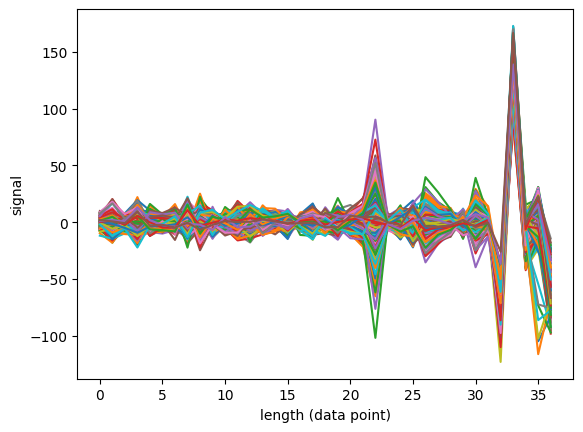

In [9]:
with open('/content/drive/MyDrive/DEAP/x_train.npy', 'rb') as file:
    sample = np.load(file, allow_pickle=True)

plt.plot(sample[0])
plt.ylabel('signal')
plt.xlabel('length (data point)')
plt.show()

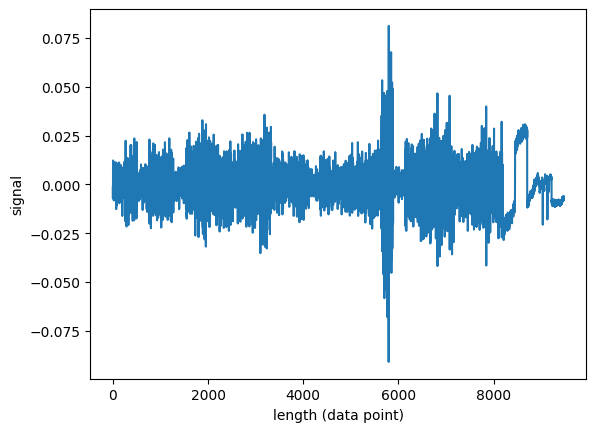

In [10]:

sample = normalize(x_train)

plt.plot(sample[0])
# plt.title("Data Sample After Z-Score Standardization")
plt.ylabel('signal')
plt.xlabel('length (data point)')
plt.show()

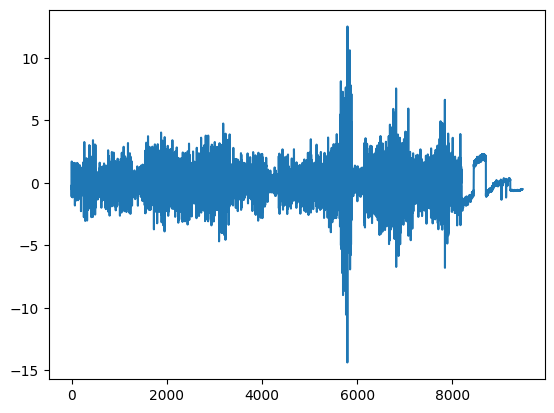

In [11]:

sample = scaler.fit_transform(normalize(x_train))

plt.plot(sample[0])
plt.show()

RESHAPE 2D BACK TO 3D

ALSO TRANSPOSE THESE ARRAYS SUCH THAT POSITIONS FOR CHANNELS AND DATA_POINTS ARE INTERCHANGED

Instead of passing all data points of a particular chaneel here we are paasing all channels for a particular data point

In [12]:
x_train = x_train.reshape(num_samples1, channels1, data_points1).transpose(0, 2, 1)
x_val = x_val.reshape(num_samples2, channels2, data_points2).transpose(0, 2, 1)
x_test = x_test.reshape(num_samples3, channels3, data_points3).transpose(0, 2, 1)

In [13]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(31744, 256, 37)
(3968, 256, 37)
(3968, 256, 37)
(31744, 4)
(3968, 4)
(3968, 4)


In [14]:
print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)
print("x_test shape:", x_test.shape)

x_train shape: (31744, 256, 37)
x_val shape: (3968, 256, 37)
x_test shape: (3968, 256, 37)


INPUT SHAPE

Data points, channels

In [15]:
input_shape=(x_train.shape[1],x_train.shape[2])
print(input_shape)

(256, 37)


In [16]:
batch_size = 32
num_classes = 4
epochs = 100

In [17]:
rate = 0.3

LSTM MODEL

In [18]:
model_3 = Sequential()

model_3.add(Conv1D(128, 3, activation='relu', input_shape=input_shape))
model_3.add(MaxPooling1D(pool_size=2))
model_3.add(Dropout(rate))

model_3.add(Conv1D(128, 3, activation='relu'))
model_3.add(MaxPooling1D(pool_size=2))
model_3.add(Dropout(rate))

model_3.add(LSTM(units = 256, return_sequences=True))
model_3.add(Dropout(rate))

model_3.add(LSTM(units=128, return_sequences=True))
model_3.add(Dropout(rate))

model_3.add(LSTM(units=64, return_sequences=True))
model_3.add(Dropout(rate))

model_3.add(LSTM(units = 32))
model_3.add(Dropout(rate))

model_3.add(Flatten())

model_3.add(Dense(units = 128, activation='relu'))
model_3.add(Dropout(rate))

model_3.add(Dense(units = num_classes))
model_3.add(Activation('softmax'))

model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 254, 128)          14336     
                                                                 
 max_pooling1d (MaxPooling1  (None, 127, 128)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 125, 128)          49280     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 62, 128)           0         
 g1D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 62, 128)           0

In [19]:
model_3.compile(
    optimizer ="adam",
    loss = 'categorical_crossentropy',
    metrics=["accuracy"]
)

In [20]:
history_3 = model_3.fit(
                    x_train, y_train,
                    epochs=100,
                    batch_size=batch_size,
                    verbose=1,
                    #class_weight=class_weights_dict,
                    validation_data=(x_val, y_val),
                    )

Epoch 1/100
992/992 [==============================] - 31s 20ms/step - loss: 1.3687 - accuracy: 0.3392 - val_loss: 1.3699 - val_accuracy: 0.3342
Epoch 2/100
992/992 [==============================] - 17s 17ms/step - loss: 1.3651 - accuracy: 0.3426 - val_loss: 1.3694 - val_accuracy: 0.3342
Epoch 3/100
992/992 [==============================] - 18s 18ms/step - loss: 1.3590 - accuracy: 0.3448 - val_loss: 1.3502 - val_accuracy: 0.3400
Epoch 4/100
992/992 [==============================] - 17s 18ms/step - loss: 1.3424 - accuracy: 0.3511 - val_loss: 1.3445 - val_accuracy: 0.3402
Epoch 5/100
992/992 [==============================] - 17s 17ms/step - loss: 1.3325 - accuracy: 0.3556 - val_loss: 1.3395 - val_accuracy: 0.3410
Epoch 6/100
992/992 [==============================] - 18s 18ms/step - loss: 1.3287 - accuracy: 0.3566 - val_loss: 1.3417 - val_accuracy: 0.3425
Epoch 7/100
992/992 [==============================] - 18s 18ms/step - loss: 1.3246 - accuracy: 0.3571 - val_loss: 1.3324 - val_ac

In [21]:
score_3 = model_3.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score_3[0])
print('Test accuracy:', score_3[1])

124/124 [==============================] - 2s 13ms/step - loss: 0.8340 - accuracy: 0.7011
Test loss: 0.8340176939964294
Test accuracy: 0.7011088728904724


SAVE MODEL

In [22]:
model_3.save('/content/drive/MyDrive/DEAP/model/lstm_model.h5')
np.save('/content/drive/MyDrive/DEAP/model/lstm_model.npy', history_3.history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


LOAD MODEL

In [23]:
directory = '/content/drive/MyDrive/DEAP/model/lstm_model.h5'
lstm_model = load_model(directory)
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 254, 128)          14336     
                                                                 
 max_pooling1d (MaxPooling1  (None, 127, 128)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 125, 128)          49280     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 62, 128)           0         
 g1D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 62, 128)           0

In [24]:
lstm_history = np.load('/content/drive/MyDrive/DEAP/model/lstm_model.npy',allow_pickle='TRUE').item()
lstm_history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

ACCURACY OF MODEL

In [25]:
print("Training Accuracy: ", np.max(lstm_history['accuracy']))
print("Training Loss: ", np.min(lstm_history['loss']))
print("Validation Accuracy: ", np.max(lstm_history['val_accuracy']))
print("Validation Loss: ", np.min(lstm_history['val_loss']))

Training Accuracy:  0.7983241081237793
Training Loss:  0.49543532729148865
Validation Accuracy:  0.7069052457809448
Validation Loss:  0.8306294083595276


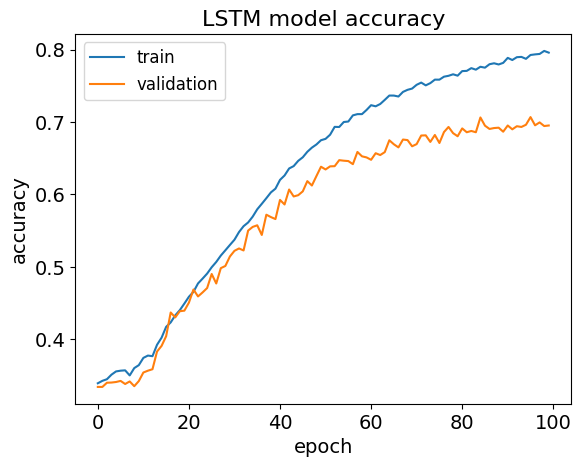

In [26]:
# summarize history for accuracy
plt.plot(lstm_history['accuracy'])
plt.plot(lstm_history['val_accuracy'])
plt.title('LSTM model accuracy', fontsize=16)
plt.ylabel('accuracy', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['train', 'validation'], loc='upper left', fontsize=12)
plt.show()

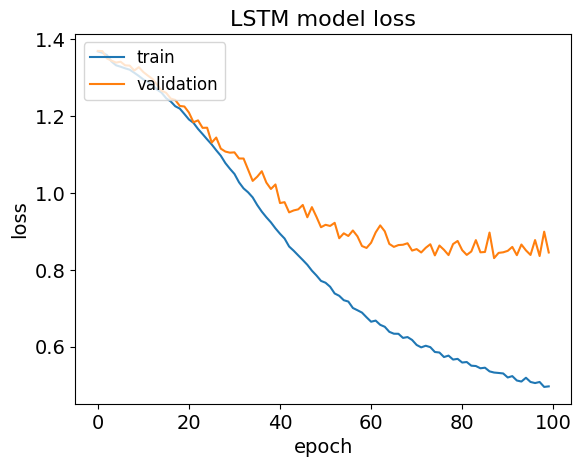

In [27]:
# summarize history for loss
plt.plot(lstm_history['loss'])
plt.plot(lstm_history['val_loss'])
plt.title('LSTM model loss', fontsize=16)
plt.ylabel('loss', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['train', 'validation'], loc='upper left', fontsize=12)
plt.show()

CONFUSION MATRIX

124/124 [==============================] - 1s 10ms/step


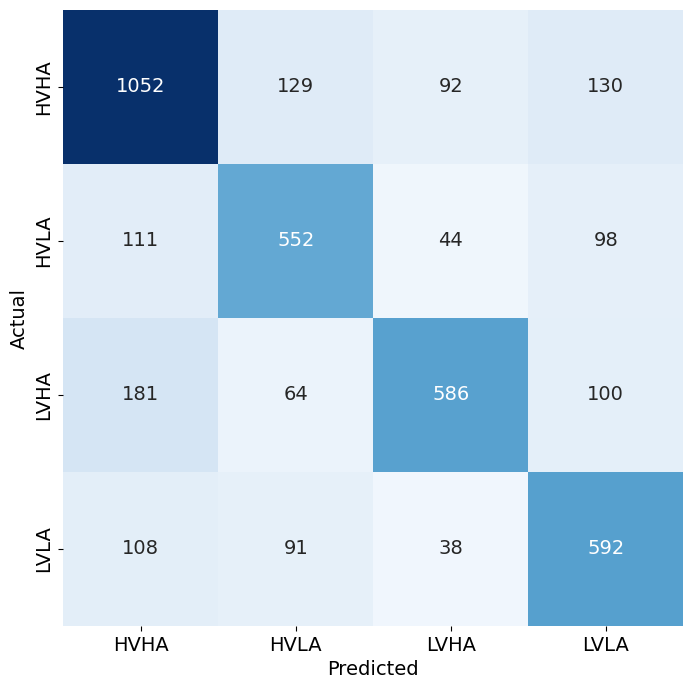

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.72      0.75      0.74      1403
           1       0.66      0.69      0.67       805
           2       0.77      0.63      0.69       931
           3       0.64      0.71      0.68       829

    accuracy                           0.70      3968
   macro avg       0.70      0.69      0.69      3968
weighted avg       0.71      0.70      0.70      3968



In [29]:
import seaborn as sns
class_names = ['HVHA', 'HVLA', 'LVHA', 'LVLA']

y_pred = lstm_model.predict(x_test)

y_predict = []

for i in range(len(y_pred)):
    y_predict.append(np.argmax(y_pred[i]))

y_predict = np.array(y_predict)
yt_test = np.argmax(y_test, axis=1)

cm = confusion_matrix(yt_test, y_predict)
clr = classification_report(yt_test, y_predict)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues', annot_kws={"size":14})
plt.xticks(np.arange(4) + 0.5, class_names, fontsize=14)
plt.yticks(np.arange(4) + 0.5, class_names, fontsize=14)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
# plt.title("Confusion Matrix for LSTM Model")
plt.show()

print("Classification Report:\n----------------------\n", clr)